In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle

In [3]:
feature_matrix = pd.read_csv('C:/Users/Administrator/Desktop/大工程/6.18data/256_6.txt', delimiter=',', header=None)
feature_matrix = feature_matrix.to_numpy()
df = pd.read_csv('C:/Users/Administrator/Desktop/大工程/mi_ln提取数据集训练测试集.csv', header=0)
print(feature_matrix.shape)
print(df.shape)

(1140, 256)
(2004, 3)


In [4]:
mi_feature = feature_matrix[645:1140]
lnc_feature = feature_matrix[0:240]
print(mi_feature.shape)
print(lnc_feature.shape)

(495, 256)
(240, 256)


In [5]:
X = []
y = df['Label'].values
for index, row in df.iterrows():
    miRNA_index = int(row['miRNA Index'])
    lncRNA_index = int(row['lncRNA Index'])
    miRNA_feature = mi_feature[miRNA_index]
    lncRNA_feature = lnc_feature[lncRNA_index]
    combined_feature = np.concatenate((miRNA_feature, lncRNA_feature))
    X.append(combined_feature)
X = np.array(X)

print(f"Combined feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Combined feature matrix shape: (2004, 512)
Labels shape: (2004,)


In [1]:
def model_train(model,X,y,filename = 'Xgboost1.pkl'):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fprs, tprs, aucs = [], [], []
    precisions, recalls, pr_aucs = [], [], []
    metrics = {'TP': [], 'TN': [], 'FP': [], 'FN': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], 'AUC': [], 'PR_AUC': []}
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        y_pred_proba_fold = model.predict_proba(X_test_fold)[:, 1]
        tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred_fold).ravel()
        metrics['TP'].append(tp)
        metrics['TN'].append(tn)
        metrics['FP'].append(fp)
        metrics['FN'].append(fn)
        metrics['Accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
        metrics['Precision'].append(precision_score(y_test_fold, y_pred_fold))
        metrics['Recall'].append(recall_score(y_test_fold, y_pred_fold))
        metrics['F1'].append(f1_score(y_test_fold, y_pred_fold))
        fpr, tpr, _ = roc_curve(y_test_fold, y_pred_proba_fold)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(roc_auc)
        precision, recall, _ = precision_recall_curve(y_test_fold, y_pred_proba_fold)
        pr_auc = average_precision_score(y_test_fold, y_pred_proba_fold)
        metrics['PR_AUC'].append(pr_auc)
        precisions.append(precision)
        recalls.append(recall)
        pr_aucs.append(pr_auc)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fprs[i], tprs[i]) for i in range(5)], axis=0)
    mean_roc_auc = auc(mean_fpr, mean_tpr)
    mean_precision = np.mean([np.interp(mean_fpr, recalls[i][::-1], precisions[i][::-1]) for i in range(5)], axis=0)
    mean_recall = mean_fpr
    mean_pr_auc = np.mean(pr_aucs)     
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i in range(5):
        plt.plot(fprs[i], tprs[i], label=f'Fold {i+1} AUC = {aucs[i]:.4f}')
    plt.plot(mean_fpr, mean_tpr, 'r--', label=f'Mean AUC = {mean_roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    for i in range(5):
        plt.plot(recalls[i], precisions[i], label=f'Fold {i+1} AUPR = {pr_aucs[i]:.4f}')
    plt.plot(mean_recall, mean_precision, 'r--', label=f'Mean AUPR = {mean_pr_auc:.4f}')
    plt.title('Precision-Recall Curves')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()
    data_to_save = {
        'TP': metrics['TP'],
        'TN': metrics['TN'],
        'FP': metrics['FP'],
        'FN': metrics['FN'],
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1': metrics['F1'],
        'AUC': metrics['AUC'],
        'PR_AUC': metrics['PR_AUC'],
        'fprs': fprs,
        'tprs': tprs,
        'aucs': aucs,
        'precisions': precisions,
        'recalls': recalls,
        'pr_aucs': pr_aucs
    }
 
    

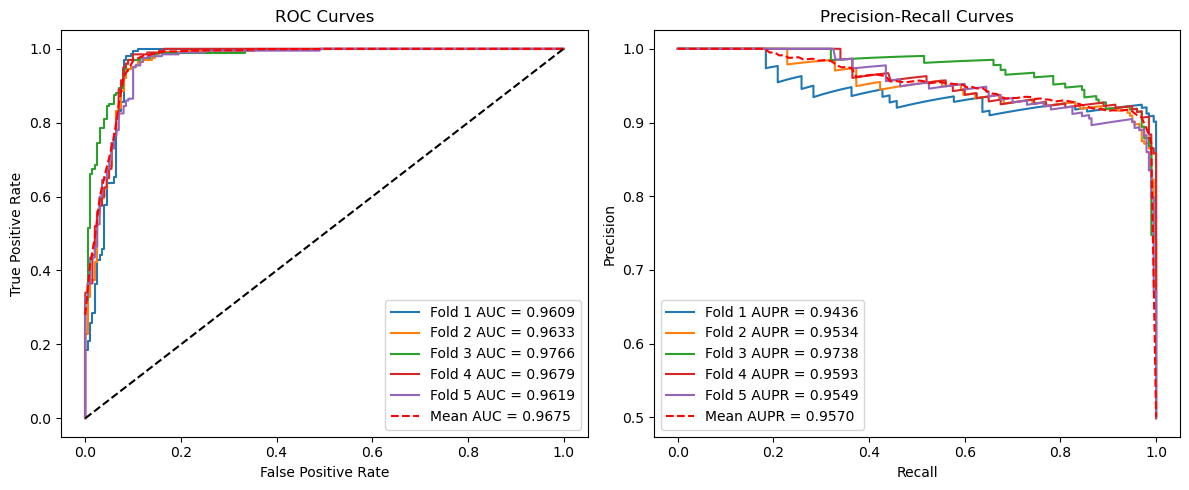

In [7]:
# XGBoost分类器
clf = XGBClassifier(n_estimators=1000, learning_rate=0.1)
model_train(clf,X,y,filename = 'XGboost.pkl')